# HR Analytics: Employee Attrition Prediction

This notebook performs EDA, builds classification models (Logistic Regression & Decision Tree), evaluates performance, and visualizes feature importance for HR attrition data.

In [48]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import joblib

## Load Dataset

In [49]:
# Load CSV (file has rows wrapped in quotes; perform a small cleanup to parse correctly)
from io import StringIO
with open('hr_attrition_synthetic.csv', 'r', encoding='utf-8') as f:
    raw = f.read()
# Strip surrounding quotes from each physical line and ignore empty lines
clean_lines = [ln.strip().strip('"') for ln in raw.splitlines() if ln.strip()!='']
cleaned = '\n'.join(clean_lines)
df = pd.read_csv(StringIO(cleaned))
df.head()

,EmployeeID,Age,Department,JobRole,MonthlyIncome,YearsAtCompany,OverTime,JobSatisfaction,EnvironmentSatisfaction,Attrition
0,1,34,Sales,Sales Executive,5000,5,Yes,3,4,No
1,2,28,Research & Development,Research Scientist,4500,2,No,4,3,No
2,3,41,Sales,Manager,9000,10,Yes,2,2,Yes
3,4,26,Human Resources,HR Specialist,4000,1,No,4,3,No
4,5,37,Research & Development,Laboratory Technician,4200,6,Yes,3,2,Yes


## Exploratory Data Analysis (EDA)

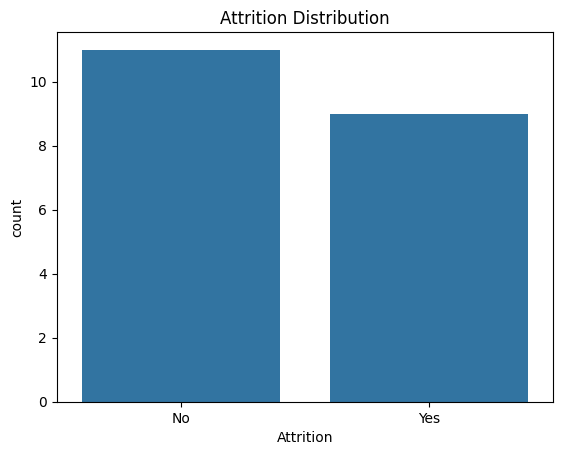

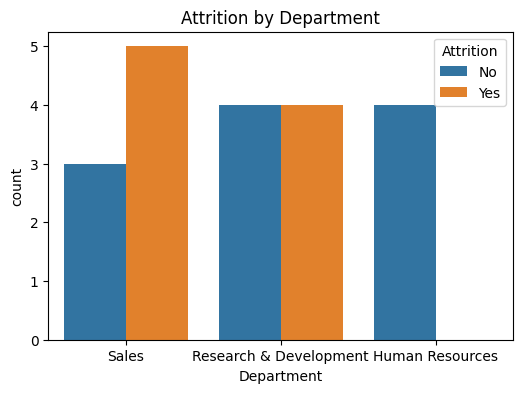

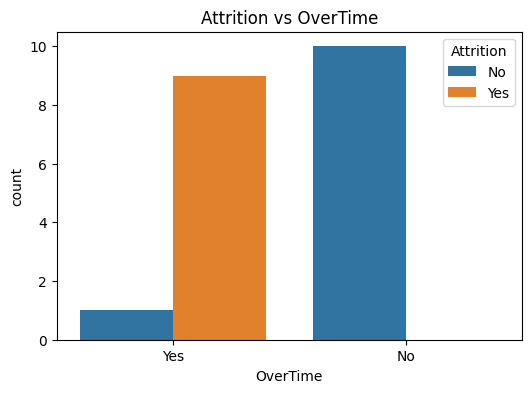

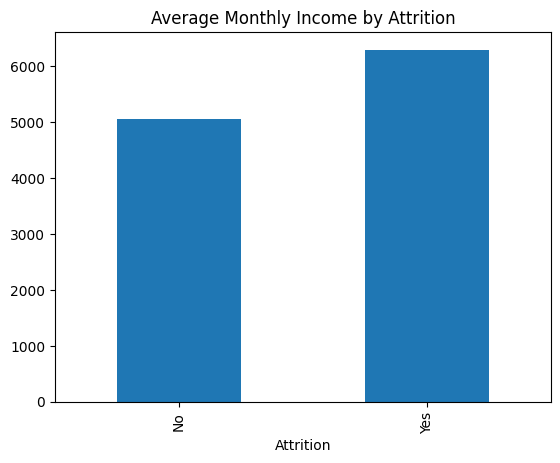

In [50]:
# Attrition distribution
# Robustly find an Attrition-like column name (handles variations like 'attrition', trailing spaces, etc.)
attr_col = None
for c in df.columns:
    if c and c.strip().lower() == 'attrition':
        attr_col = c
        break
if attr_col is None:
    # try a fuzzy match for common variants
    for c in df.columns:
        if c and 'attrit' in c.strip().lower():
            attr_col = c
            break
if attr_col is None:
    raise ValueError(f"Could not find an 'Attrition' column in df. Available columns: {list(df.columns)}")

sns.countplot(x=attr_col, data=df)
plt.title('Attrition Distribution')
plt.show()

# Attrition by Department
plt.figure(figsize=(6,4))
dept_col = 'Department' if 'Department' in df.columns else None
if dept_col is None:
    dept_candidates = [c for c in df.columns if 'dept' in c.strip().lower()]
    dept_col = dept_candidates[0] if dept_candidates else None
if dept_col is None:
    print('No Department-like column found; skipping department plot')
else:
    sns.countplot(x=dept_col, hue=attr_col, data=df)
    plt.title('Attrition by Department')
    plt.show()

# Attrition vs OverTime
plt.figure(figsize=(6,4))
ot_col = 'OverTime' if 'OverTime' in df.columns else None
if ot_col is None:
    ot_candidates = [c for c in df.columns if 'overtime' in c.strip().lower()]
    ot_col = ot_candidates[0] if ot_candidates else None
if ot_col is None:
    print('No OverTime-like column found; skipping OverTime plot')
else:
    sns.countplot(x=ot_col, hue=attr_col, data=df)
    plt.title('Attrition vs OverTime')
    plt.show()

# Average MonthlyIncome by Attrition
mi_col = 'MonthlyIncome' if 'MonthlyIncome' in df.columns else None
if mi_col is None:
    mi_candidates = [c for c in df.columns if 'income' in c.strip().lower() or 'monthly' in c.strip().lower()]
    mi_col = mi_candidates[0] if mi_candidates else None
if mi_col is None:
    print('No MonthlyIncome-like column found; skipping income plot')
else:
    df.groupby(attr_col)[mi_col].mean().plot(kind='bar')
    plt.title('Average Monthly Income by Attrition')
    plt.show()

## Preprocessing & Feature Selection

In [51]:
target = 'Attrition'
X = df.drop(columns=[target])
y = (df[target] == 'Yes').astype(int)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## Train-Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Train Models

In [53]:
# Logistic Regression Pipeline
log_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print('Logistic Regression Accuracy:', acc_log)

# Decision Tree Pipeline
tree_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(max_depth=6, random_state=42))])
tree_pipe.fit(X_train, y_train)
y_pred_tree = tree_pipe.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
print('Decision Tree Accuracy:', acc_tree)

Logistic Regression Accuracy: 1.0
Decision Tree Accuracy: 1.0


## Model Evaluation

In [54]:
# Confusion Matrices
cm_log = confusion_matrix(y_test, y_pred_log)
cm_tree = confusion_matrix(y_test, y_pred_tree)

print('Logistic Regression Confusion Matrix:\n', cm_log)
print('Decision Tree Confusion Matrix:\n', cm_tree)

print('Decision Tree Classification Report:\n', classification_report(y_test, y_pred_tree))

Logistic Regression Confusion Matrix:
 [[3 0]
 [0 2]]
Decision Tree Confusion Matrix:
 [[3 0]
 [0 2]]
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



## Feature Importance (Permutation Importance)

In [55]:
r = permutation_importance(tree_pipe, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)
print('Top Features:')
print(importances.head(10))

Top Features:
OverTime                   0.4
EmployeeID                 0.0
Age                        0.0
JobRole                    0.0
Department                 0.0
MonthlyIncome              0.0
YearsAtCompany             0.0
JobSatisfaction            0.0
EnvironmentSatisfaction    0.0
dtype: float64


## Save Models

In [56]:
joblib.dump(log_pipe, 'logistic_pipeline.joblib')
joblib.dump(tree_pipe, 'tree_pipeline.joblib')

['tree_pipeline.joblib']

## Save Evaluation Summary

In [57]:
with open('evaluation_summary.txt', 'w') as f:
    f.write(f'Logistic Regression Accuracy: {acc_log}\n')
    f.write(f'Decision Tree Accuracy: {acc_tree}\n')
    f.write('Decision Tree Classification Report:\n')
    f.write(classification_report(y_test, y_pred_tree))